# IMPORT

In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
sns.set(font_scale=2) 
from tqdm import tqdm

%matplotlib inline
import torch
import torchvision
from PIL import Image
import random
import pickle

In [3]:
random_seed = 629

In [4]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# Load data

In [5]:
df = pd.read_pickle("raw_data/LSWMD.pkl")

In [6]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


# EDA & PreProcess

In [128]:
df = df.drop(['waferIndex', 'dieSize', 'lotName'], axis = 1)

In [7]:
#add wafermapDim column because waferMap dim is different each other.
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
480191,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot29750,25.0,[],[],"(33, 33)"
124002,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2856.0,lot8238,17.0,[],[],"(59, 62)"
82760,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1801.0,lot5915,19.0,[],[],"(56, 41)"
189542,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2,...",533.0,lot12057,16.0,[],[],"(26, 26)"
782715,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1414.0,lot46375,8.0,[[Test]],[[none]],"(42, 44)"


In [8]:
#To check failureType# and class dist.
df['failureNum'] = df.failureType
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
df=df.replace({'failureNum':mapping_type})

/opt/conda/lib/python3.8/site-packages/pandas/core/array_algos/replace.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [9]:
df_training = df[df['trianTestLabel'] == 'Training']
defect_train = df_training[df_training['failureType'] != 'none']
defect_train = defect_train.reset_index()

df_test = df[df['trianTestLabel'] == 'Test']
defect_test = df_test[df_test['failureType'] != 'none']
defect_test = defect_test.reset_index()

/opt/conda/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/conda/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [10]:
none_train = df_training[df_training['failureType'] == 'none']

In [11]:
none_defect = none_train.sample(3000, random_state = 629)
# none_test = none_test.sample(1000, random_state = 629)

In [12]:
df_withlabel = df[(df['failureType']!=0)]
df_withlabel =df_withlabel.reset_index() #labeled index.
df_withpattern = df_withlabel[(df_withlabel['failureType'] != 'none')]
df_withpattern = df_withpattern.reset_index() #patterned index.

/opt/conda/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [13]:
X = pd.concat([df_withpattern, none_defect], axis = 0)

In [14]:
X.shape

(28519, 10)

## Implementation of c median filter algorithm

In [15]:
def mean_filter(img):
    img_cpy = np.copy(img)
    height = img_cpy.shape[0]
    width = img_cpy.shape[1]
    for h in range(1,height):
        for w in range(1,width):
            if img_cpy[h][w] == 2.0:
                filter_area = img_cpy[h-1:h+2, w-1:w+2]
                filter_area = np.where(filter_area == 2.0, filter_area, 0)
                if (filter_area == 2.0).sum() - 1.0 == 0.0:
                    img_cpy[h][w] = 1.0
                else:
                    mean = (filter_area.sum())/((filter_area == 2.0).sum() - 1.0 )
                    if mean >= 1.25:
                        img_cpy[h][w] = 2.0
                    
    return img_cpy

In [16]:
# def mean_filter(img):
#     img_cpy = np.copy(img)
#     height = img_cpy.shape[0]
#     width = img_cpy.shape[1]
#     for h in range(1,height):
#         for w in range(1,width):
#             if img_cpy[h][w] == 2.0:
#                 filter_area = img_cpy[h-1:h+2, w-1:w+2]
#                 zero_count = (filter_area == 0.0).sum()
#                 neighbor_mean = (filter_area.sum()-2.0)/(8 - zero_count)
#                 if neighbor_mean < 1.25:
#                     img_cpy[h][w] = 1.0
#     return img_cpy

6


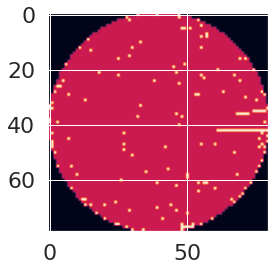

In [17]:
i = 11000
img_array =Image.fromarray(defect_train.iloc[i]['waferMap'])
label = defect_train.iloc[i]['failureNum'] 
plt.imshow(img_array)
print(label)

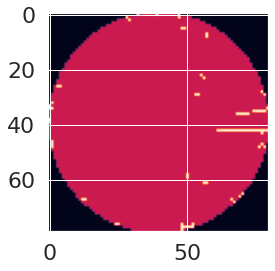

In [18]:
img_array = defect_train.iloc[i]['waferMap'] 
img_array = img_array.astype('float64')
img_array = mean_filter(img_array)
img_array =Image.fromarray(img_array.astype('uint8'))
plt.imshow(img_array)

## preprocess

In [19]:
def resize_arr(df):
    x = []
    y = []
    for i in tqdm(range(len(df))):
        img_array = df.iloc[i]['waferMap'] 
        label = df.iloc[i]['failureNum'] 
        img_array = mean_filter(img_array)
        img_array =Image.fromarray(img_array)
        im_resized = img_array.resize((64,64), Image.NEAREST)
        img_array = np.array(im_resized, dtype = 'f')
        y.append(label)
        x.append(img_array)
    x = np.array(x)
    return np.array(x), np.array(y)

In [141]:
X_, label = resize_arr(X)
np.unique(label, return_counts = True)     

  0%|                                                                                         | 0/28519 [00:00<?, ?it/s]/tmp/ipykernel_2466648/2243927867.py:9: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  im_resized = img_array.resize((64,64), Image.NEAREST)
100%|████████████████████████████████████████████████████████████████████████████| 28519/28519 [03:16<00:00, 145.19it/s]


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([4294,  555, 5189, 9680, 3593,  866, 1193,  149, 3000]))

In [ ]:
# mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}

In [147]:
target_idx[0]

array([    0,     5,    10, ..., 25489, 25491, 25492])

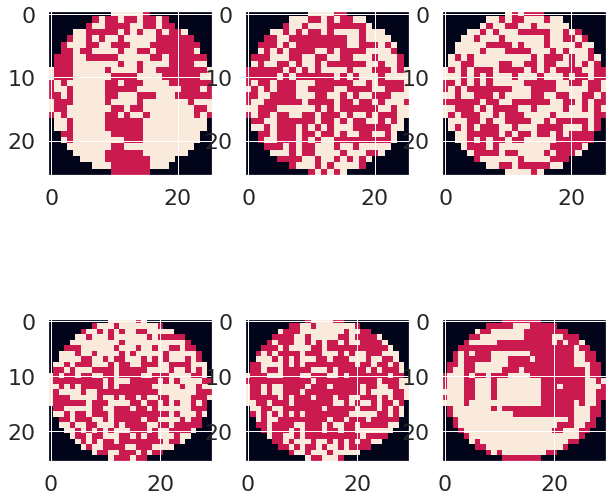

In [154]:
target_idx = np.where(label == 5)
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(  X.iloc[target_idx[0][1]]['waferMap']  )
plt.subplot(2,3,2)
plt.imshow(  X.iloc[target_idx[0][2]]['waferMap'])
plt.subplot(2,3,3)
plt.imshow(  X.iloc[target_idx[0][3]]['waferMap'])
plt.subplot(2,3,4)
plt.imshow(  X.iloc[target_idx[0][-1]]['waferMap'])
plt.subplot(2,3,5)
plt.imshow(  X.iloc[target_idx[0][-2]]['waferMap'])
plt.subplot(2,3,6)
plt.imshow(  X.iloc[target_idx[0][-4]]['waferMap'])

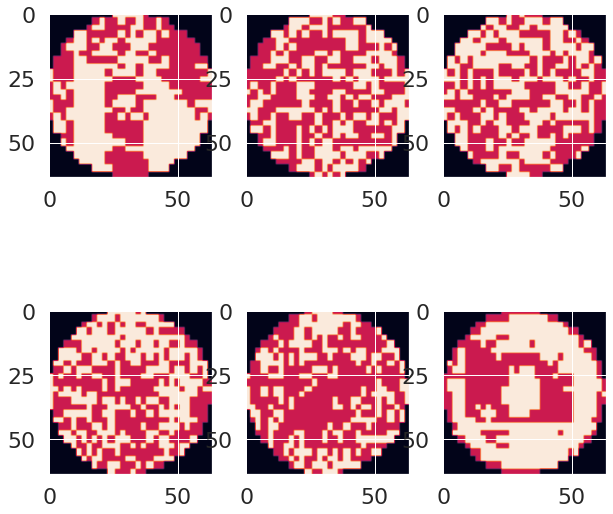

In [153]:
target_idx = np.where(label == 5)
plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
plt.imshow(X_[target_idx[0][1]])
plt.subplot(2,3,2)
plt.imshow(  X_[target_idx[0][2]])
plt.subplot(2,3,3)
plt.imshow(  X_[target_idx[0][3]])
plt.subplot(2,3,4)
plt.imshow(  X_[target_idx[0][-1]]  )
plt.subplot(2,3,5)
plt.imshow(  X_[target_idx[0][-2]])
plt.subplot(2,3,6)
plt.imshow(  X_[target_idx[0][-3]])

In [98]:
def shuffle_idx(label):
    train_idx = []
    valid_idx = []
    test_idx = []
    train_label = []
    valid_label = []
    test_label = []
    for defect in range(0, 8+1):
        target_defect = np.where(label == defect)[0]
        np.random.shuffle(target_defect)
        training_size = int(len(target_defect)*0.60)
        valid_size = int(len(target_defect)*0.15)
        defect_train = target_defect[:training_size]
        defect_valid = target_defect[training_size:training_size+valid_size]
        defect_test = target_defect[training_size+valid_size:]
        train_idx.extend(list(defect_train))
        valid_idx.extend(list(defect_valid))
        test_idx.extend(list(defect_test))
        train_label.extend([defect] * len(defect_train))
        valid_label.extend([defect] * len(defect_valid))
        test_label.extend([defect] * len(defect_test))
    return train_idx, valid_idx, test_idx, train_label, valid_label, test_label


In [99]:
train_idx, valid_idx, test_idx, train_label, valid_label, test_label = shuffle_idx(label)

In [100]:
np.unique(valid_label, return_counts = True)  

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 644,   83,  778, 1452,  538,  129,  178,   22,  450]))

In [105]:
X = torch.Tensor(X).unsqueeze(1)

In [106]:
X.shape

torch.Size([28519, 1, 64, 64])

In [107]:
base = torch.zeros(1,64,64)
for idx in tqdm(train_idx):
    base = torch.cat([base, X[idx]], axis = 0)
train = base[1:]

base = torch.zeros(1,64,64)
for idx in tqdm(valid_idx):
    base = torch.cat([base, X[idx]], axis = 0)
valid = base[1:]

base = torch.zeros(1,64,64)
for idx in tqdm(test_idx):
    base = torch.cat([base, X[idx]], axis = 0)
test = base[1:]

100%|██████████████████████████████████████████████████████████████████████████████| 7137/7137 [00:38<00:00, 186.89it/s]


In [108]:
print(train.shape)
print(len(train_label))

torch.Size([17108, 64, 64])
17108


In [109]:
import pickle 

with open('data/X_train.pickle', 'wb') as handle:
    pickle.dump(train, handle, protocol = pickle.HIGHEST_PROTOCOL)    
with open('data/y_train.pickle', 'wb') as handle:
    pickle.dump(train_label, handle, protocol = pickle.HIGHEST_PROTOCOL)    

with open('data/X_valid.pickle', 'wb') as handle:
    pickle.dump(valid, handle, protocol = pickle.HIGHEST_PROTOCOL)    
with open('data/y_valid.pickle', 'wb') as handle:
    pickle.dump(valid_label, handle, protocol = pickle.HIGHEST_PROTOCOL)    

with open('data/X_test.pickle', 'wb') as handle:
    pickle.dump(test, handle, protocol = pickle.HIGHEST_PROTOCOL)    
with open('data/y_test.pickle', 'wb') as handle:
    pickle.dump(test_label, handle, protocol = pickle.HIGHEST_PROTOCOL)    